# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

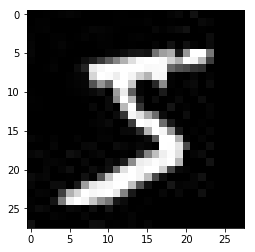

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:3], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

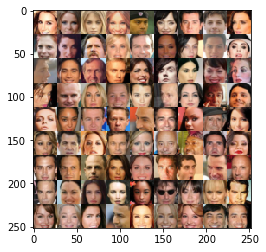

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:99], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None))
    return inputs_real, inputs_z, learning_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    x = images
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse= not is_train):

        x1 = tf.layers.dense(z, 2*2*512)

        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)        
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)


        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
       
        
        out = tf.tanh(logits)
 
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_out_real,d_logits_real = discriminator(input_real, False)
    d_out_fake,d_logits_fake = discriminator(g_model, True)
    

    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))    
    
    
    return d_loss, g_loss    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.6082... Generator Loss: 1.6197
Epoch 1/2... Discriminator Loss: 0.4040... Generator Loss: 3.7359
Epoch 1/2... Discriminator Loss: 0.7098... Generator Loss: 1.3183
Epoch 1/2... Discriminator Loss: 2.2504... Generator Loss: 14.5144
Epoch 1/2... Discriminator Loss: 0.4638... Generator Loss: 2.5982
Epoch 1/2... Discriminator Loss: 0.4255... Generator Loss: 9.0610
Epoch 1/2... Discriminator Loss: 2.6130... Generator Loss: 0.2158
Epoch 1/2... Discriminator Loss: 0.8162... Generator Loss: 11.5833
Epoch 1/2... Discriminator Loss: 0.6476... Generator Loss: 2.5220
Epoch 1/2... Discriminator Loss: 0.7107... Generator Loss: 2.0220


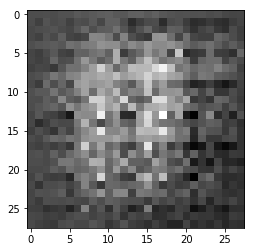

Epoch 1/2... Discriminator Loss: 0.7130... Generator Loss: 1.6816
Epoch 1/2... Discriminator Loss: 0.4919... Generator Loss: 3.8675
Epoch 1/2... Discriminator Loss: 0.4179... Generator Loss: 3.6315
Epoch 1/2... Discriminator Loss: 0.5467... Generator Loss: 2.0957
Epoch 1/2... Discriminator Loss: 0.4348... Generator Loss: 3.3685
Epoch 1/2... Discriminator Loss: 0.5213... Generator Loss: 2.4331
Epoch 1/2... Discriminator Loss: 0.3904... Generator Loss: 3.8031
Epoch 1/2... Discriminator Loss: 0.3846... Generator Loss: 4.1419
Epoch 1/2... Discriminator Loss: 0.3681... Generator Loss: 4.6255
Epoch 1/2... Discriminator Loss: 0.3641... Generator Loss: 4.4033


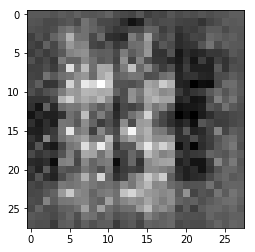

Epoch 1/2... Discriminator Loss: 0.4175... Generator Loss: 2.8844
Epoch 1/2... Discriminator Loss: 0.3643... Generator Loss: 4.6377
Epoch 1/2... Discriminator Loss: 0.3812... Generator Loss: 3.9614
Epoch 1/2... Discriminator Loss: 0.5947... Generator Loss: 1.8375
Epoch 1/2... Discriminator Loss: 0.3975... Generator Loss: 3.9045
Epoch 1/2... Discriminator Loss: 0.3688... Generator Loss: 4.5354
Epoch 1/2... Discriminator Loss: 0.3547... Generator Loss: 4.5238
Epoch 1/2... Discriminator Loss: 0.3594... Generator Loss: 4.3207
Epoch 1/2... Discriminator Loss: 0.4088... Generator Loss: 3.0913
Epoch 1/2... Discriminator Loss: 0.5026... Generator Loss: 2.4497


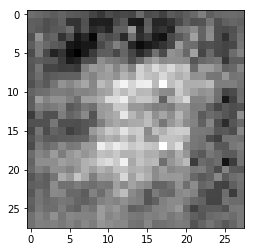

Epoch 1/2... Discriminator Loss: 0.4180... Generator Loss: 5.2014
Epoch 1/2... Discriminator Loss: 0.5003... Generator Loss: 3.7883
Epoch 1/2... Discriminator Loss: 0.4193... Generator Loss: 3.5827
Epoch 1/2... Discriminator Loss: 0.4375... Generator Loss: 2.7415
Epoch 1/2... Discriminator Loss: 0.4172... Generator Loss: 3.5292
Epoch 1/2... Discriminator Loss: 0.3839... Generator Loss: 3.8168
Epoch 1/2... Discriminator Loss: 0.3791... Generator Loss: 4.2457
Epoch 1/2... Discriminator Loss: 0.4264... Generator Loss: 3.4086
Epoch 1/2... Discriminator Loss: 0.4040... Generator Loss: 3.4198
Epoch 1/2... Discriminator Loss: 0.5354... Generator Loss: 2.0632


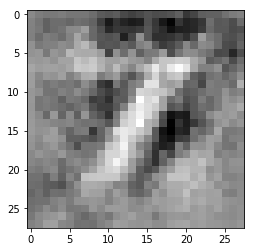

Epoch 1/2... Discriminator Loss: 0.3733... Generator Loss: 4.5971
Epoch 1/2... Discriminator Loss: 0.4606... Generator Loss: 5.5950
Epoch 1/2... Discriminator Loss: 0.4123... Generator Loss: 4.8107
Epoch 1/2... Discriminator Loss: 0.3697... Generator Loss: 4.0279
Epoch 1/2... Discriminator Loss: 0.3935... Generator Loss: 3.3136
Epoch 1/2... Discriminator Loss: 0.4928... Generator Loss: 2.4159
Epoch 1/2... Discriminator Loss: 1.4870... Generator Loss: 1.4203
Epoch 1/2... Discriminator Loss: 1.0594... Generator Loss: 1.0915
Epoch 1/2... Discriminator Loss: 0.4390... Generator Loss: 3.8630
Epoch 1/2... Discriminator Loss: 0.3922... Generator Loss: 3.4169


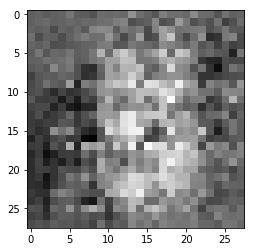

Epoch 1/2... Discriminator Loss: 0.3936... Generator Loss: 3.9958
Epoch 1/2... Discriminator Loss: 0.3809... Generator Loss: 3.9496
Epoch 1/2... Discriminator Loss: 0.3850... Generator Loss: 3.5537
Epoch 1/2... Discriminator Loss: 0.4490... Generator Loss: 5.3156
Epoch 1/2... Discriminator Loss: 0.6059... Generator Loss: 3.4102
Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 4.7056
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 0.5888
Epoch 1/2... Discriminator Loss: 1.1562... Generator Loss: 0.9628
Epoch 1/2... Discriminator Loss: 0.7163... Generator Loss: 1.7020
Epoch 1/2... Discriminator Loss: 0.9423... Generator Loss: 1.1257


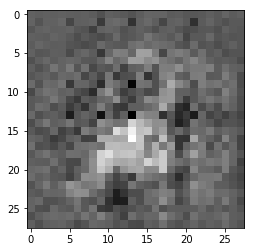

Epoch 1/2... Discriminator Loss: 0.6449... Generator Loss: 2.6250
Epoch 1/2... Discriminator Loss: 0.6430... Generator Loss: 1.7695
Epoch 1/2... Discriminator Loss: 0.5573... Generator Loss: 2.3625
Epoch 1/2... Discriminator Loss: 0.5209... Generator Loss: 2.4005
Epoch 1/2... Discriminator Loss: 0.6417... Generator Loss: 1.5995
Epoch 1/2... Discriminator Loss: 0.5870... Generator Loss: 2.5872
Epoch 1/2... Discriminator Loss: 0.5598... Generator Loss: 2.1959
Epoch 1/2... Discriminator Loss: 0.5827... Generator Loss: 1.9730
Epoch 1/2... Discriminator Loss: 0.4569... Generator Loss: 3.4254
Epoch 1/2... Discriminator Loss: 0.4504... Generator Loss: 2.7548


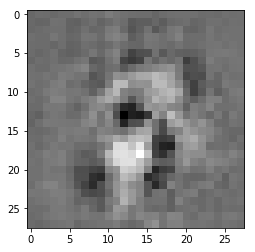

Epoch 1/2... Discriminator Loss: 0.4337... Generator Loss: 2.9063
Epoch 1/2... Discriminator Loss: 0.4952... Generator Loss: 2.2278
Epoch 1/2... Discriminator Loss: 0.4509... Generator Loss: 2.9039
Epoch 1/2... Discriminator Loss: 0.4204... Generator Loss: 3.2817
Epoch 1/2... Discriminator Loss: 0.4425... Generator Loss: 2.7889
Epoch 1/2... Discriminator Loss: 0.8160... Generator Loss: 1.2272
Epoch 1/2... Discriminator Loss: 0.5496... Generator Loss: 1.9729
Epoch 1/2... Discriminator Loss: 0.5633... Generator Loss: 1.8821
Epoch 1/2... Discriminator Loss: 0.4659... Generator Loss: 2.3905
Epoch 1/2... Discriminator Loss: 0.4411... Generator Loss: 3.1238


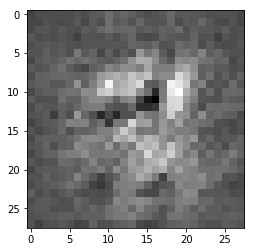

Epoch 1/2... Discriminator Loss: 0.4635... Generator Loss: 2.4798
Epoch 1/2... Discriminator Loss: 0.4806... Generator Loss: 2.9283
Epoch 1/2... Discriminator Loss: 0.4256... Generator Loss: 3.0340
Epoch 1/2... Discriminator Loss: 0.4710... Generator Loss: 3.7562
Epoch 1/2... Discriminator Loss: 0.4768... Generator Loss: 2.9596
Epoch 1/2... Discriminator Loss: 0.4095... Generator Loss: 5.4855
Epoch 1/2... Discriminator Loss: 0.4726... Generator Loss: 2.5001
Epoch 1/2... Discriminator Loss: 0.4892... Generator Loss: 2.4093
Epoch 1/2... Discriminator Loss: 0.4923... Generator Loss: 2.2964
Epoch 1/2... Discriminator Loss: 0.4047... Generator Loss: 3.5827


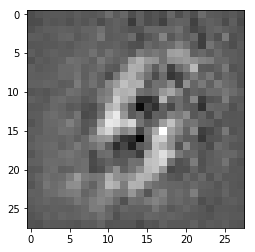

Epoch 1/2... Discriminator Loss: 0.3888... Generator Loss: 3.9259
Epoch 1/2... Discriminator Loss: 0.4328... Generator Loss: 4.1178
Epoch 1/2... Discriminator Loss: 0.4091... Generator Loss: 2.9457
Epoch 2/2... Discriminator Loss: 0.3904... Generator Loss: 4.2687
Epoch 2/2... Discriminator Loss: 0.4305... Generator Loss: 2.7500
Epoch 2/2... Discriminator Loss: 0.3964... Generator Loss: 3.8764
Epoch 2/2... Discriminator Loss: 0.8867... Generator Loss: 6.3650
Epoch 2/2... Discriminator Loss: 0.4349... Generator Loss: 2.7693
Epoch 2/2... Discriminator Loss: 0.4085... Generator Loss: 3.2954
Epoch 2/2... Discriminator Loss: 0.3889... Generator Loss: 3.2603
Epoch 2/2... Discriminator Loss: 0.4140... Generator Loss: 3.6787
Epoch 2/2... Discriminator Loss: 0.3909... Generator Loss: 3.8802
Epoch 2/2... Discriminator Loss: 0.5753... Generator Loss: 1.8556


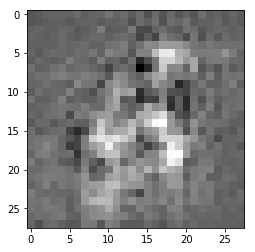

Epoch 2/2... Discriminator Loss: 0.3743... Generator Loss: 3.8522
Epoch 2/2... Discriminator Loss: 0.4137... Generator Loss: 5.0682
Epoch 2/2... Discriminator Loss: 0.4220... Generator Loss: 3.6617
Epoch 2/2... Discriminator Loss: 0.4632... Generator Loss: 2.3799
Epoch 2/2... Discriminator Loss: 0.3825... Generator Loss: 3.6728
Epoch 2/2... Discriminator Loss: 0.3767... Generator Loss: 3.7404
Epoch 2/2... Discriminator Loss: 0.3863... Generator Loss: 3.4787
Epoch 2/2... Discriminator Loss: 0.3923... Generator Loss: 3.2420
Epoch 2/2... Discriminator Loss: 0.3871... Generator Loss: 3.7660
Epoch 2/2... Discriminator Loss: 0.4016... Generator Loss: 3.8282


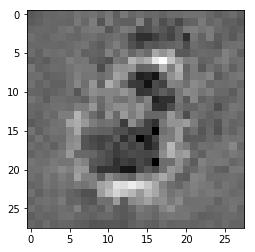

Epoch 2/2... Discriminator Loss: 0.3811... Generator Loss: 4.0720
Epoch 2/2... Discriminator Loss: 0.3886... Generator Loss: 3.3857
Epoch 2/2... Discriminator Loss: 0.4079... Generator Loss: 3.1783
Epoch 2/2... Discriminator Loss: 0.3757... Generator Loss: 3.7526
Epoch 2/2... Discriminator Loss: 0.3785... Generator Loss: 3.4759
Epoch 2/2... Discriminator Loss: 0.3781... Generator Loss: 3.6878
Epoch 2/2... Discriminator Loss: 2.5172... Generator Loss: 5.6927
Epoch 2/2... Discriminator Loss: 0.9133... Generator Loss: 1.0962
Epoch 2/2... Discriminator Loss: 1.4865... Generator Loss: 0.6313
Epoch 2/2... Discriminator Loss: 0.6186... Generator Loss: 2.2831


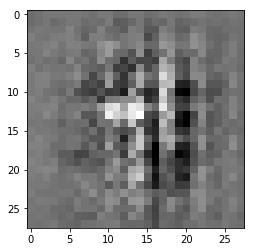

Epoch 2/2... Discriminator Loss: 0.5398... Generator Loss: 2.5376
Epoch 2/2... Discriminator Loss: 0.5539... Generator Loss: 2.2303
Epoch 2/2... Discriminator Loss: 0.4580... Generator Loss: 2.4916
Epoch 2/2... Discriminator Loss: 0.4076... Generator Loss: 3.0556
Epoch 2/2... Discriminator Loss: 0.4324... Generator Loss: 3.1648
Epoch 2/2... Discriminator Loss: 0.5117... Generator Loss: 3.0578
Epoch 2/2... Discriminator Loss: 0.4467... Generator Loss: 2.9917
Epoch 2/2... Discriminator Loss: 0.3758... Generator Loss: 3.4990
Epoch 2/2... Discriminator Loss: 0.4122... Generator Loss: 3.0753
Epoch 2/2... Discriminator Loss: 0.3967... Generator Loss: 3.0920


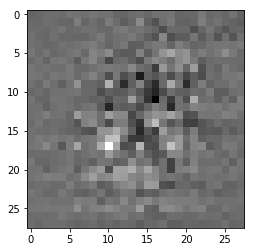

Epoch 2/2... Discriminator Loss: 0.3682... Generator Loss: 4.6711
Epoch 2/2... Discriminator Loss: 0.4321... Generator Loss: 2.6219
Epoch 2/2... Discriminator Loss: 0.4257... Generator Loss: 2.6330
Epoch 2/2... Discriminator Loss: 0.3799... Generator Loss: 3.8909
Epoch 2/2... Discriminator Loss: 0.3700... Generator Loss: 4.0487
Epoch 2/2... Discriminator Loss: 0.3909... Generator Loss: 3.8234
Epoch 2/2... Discriminator Loss: 0.3955... Generator Loss: 3.0963
Epoch 2/2... Discriminator Loss: 0.3849... Generator Loss: 3.4431
Epoch 2/2... Discriminator Loss: 0.4063... Generator Loss: 3.5248
Epoch 2/2... Discriminator Loss: 0.3581... Generator Loss: 4.1543


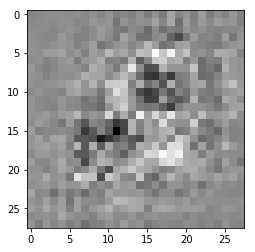

Epoch 2/2... Discriminator Loss: 0.3680... Generator Loss: 3.6967
Epoch 2/2... Discriminator Loss: 0.3758... Generator Loss: 3.7311
Epoch 2/2... Discriminator Loss: 0.3803... Generator Loss: 3.4344
Epoch 2/2... Discriminator Loss: 0.3873... Generator Loss: 3.4073
Epoch 2/2... Discriminator Loss: 0.3715... Generator Loss: 3.6407
Epoch 2/2... Discriminator Loss: 0.3524... Generator Loss: 4.9812
Epoch 2/2... Discriminator Loss: 0.3724... Generator Loss: 3.6712
Epoch 2/2... Discriminator Loss: 0.3623... Generator Loss: 4.2638
Epoch 2/2... Discriminator Loss: 0.3904... Generator Loss: 3.2137
Epoch 2/2... Discriminator Loss: 0.3686... Generator Loss: 3.5892


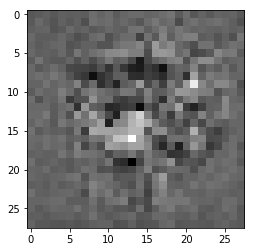

Epoch 2/2... Discriminator Loss: 0.5309... Generator Loss: 2.0556
Epoch 2/2... Discriminator Loss: 0.3521... Generator Loss: 4.6047
Epoch 2/2... Discriminator Loss: 0.3675... Generator Loss: 3.7844
Epoch 2/2... Discriminator Loss: 0.3702... Generator Loss: 3.6232
Epoch 2/2... Discriminator Loss: 0.3559... Generator Loss: 4.4780
Epoch 2/2... Discriminator Loss: 0.3675... Generator Loss: 3.9481
Epoch 2/2... Discriminator Loss: 0.4719... Generator Loss: 3.1854
Epoch 2/2... Discriminator Loss: 1.0631... Generator Loss: 0.9094
Epoch 2/2... Discriminator Loss: 0.5569... Generator Loss: 1.8715
Epoch 2/2... Discriminator Loss: 0.5819... Generator Loss: 1.9240


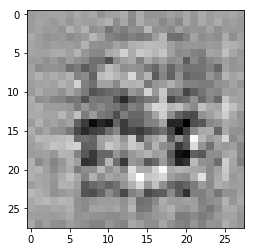

Epoch 2/2... Discriminator Loss: 0.6965... Generator Loss: 1.8982
Epoch 2/2... Discriminator Loss: 0.4588... Generator Loss: 2.9953
Epoch 2/2... Discriminator Loss: 0.4009... Generator Loss: 3.4624
Epoch 2/2... Discriminator Loss: 0.3750... Generator Loss: 4.3908
Epoch 2/2... Discriminator Loss: 0.3854... Generator Loss: 3.9688
Epoch 2/2... Discriminator Loss: 0.4084... Generator Loss: 3.3671
Epoch 2/2... Discriminator Loss: 0.4727... Generator Loss: 2.2743
Epoch 2/2... Discriminator Loss: 0.4376... Generator Loss: 2.9880
Epoch 2/2... Discriminator Loss: 0.4174... Generator Loss: 2.8652
Epoch 2/2... Discriminator Loss: 0.4037... Generator Loss: 3.2741


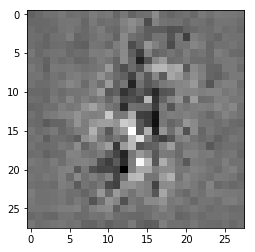

Epoch 2/2... Discriminator Loss: 0.3564... Generator Loss: 4.7371
Epoch 2/2... Discriminator Loss: 0.3966... Generator Loss: 3.0433
Epoch 2/2... Discriminator Loss: 0.3896... Generator Loss: 4.9711
Epoch 2/2... Discriminator Loss: 0.4029... Generator Loss: 4.4270
Epoch 2/2... Discriminator Loss: 0.3867... Generator Loss: 6.2553
Epoch 2/2... Discriminator Loss: 0.3950... Generator Loss: 4.4466
Epoch 2/2... Discriminator Loss: 0.3597... Generator Loss: 4.2413
Epoch 2/2... Discriminator Loss: 0.3817... Generator Loss: 3.4222
Epoch 2/2... Discriminator Loss: 0.3739... Generator Loss: 3.4978
Epoch 2/2... Discriminator Loss: 0.3828... Generator Loss: 3.7271


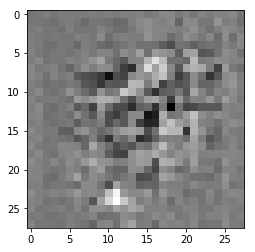

Epoch 2/2... Discriminator Loss: 0.3813... Generator Loss: 3.4726
Epoch 2/2... Discriminator Loss: 0.3568... Generator Loss: 4.3076
Epoch 2/2... Discriminator Loss: 0.3526... Generator Loss: 4.5775


In [26]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/2... Discriminator Loss: 1.3973... Generator Loss: 12.6231
Epoch 1/2... Discriminator Loss: 1.9466... Generator Loss: 0.2521
Epoch 1/2... Discriminator Loss: 0.4920... Generator Loss: 6.5553
Epoch 1/2... Discriminator Loss: 0.4910... Generator Loss: 2.4959
Epoch 1/2... Discriminator Loss: 0.5350... Generator Loss: 2.4642
Epoch 1/2... Discriminator Loss: 0.6782... Generator Loss: 1.4972
Epoch 1/2... Discriminator Loss: 0.4829... Generator Loss: 5.9026
Epoch 1/2... Discriminator Loss: 1.1739... Generator Loss: 11.1431
Epoch 1/2... Discriminator Loss: 0.5689... Generator Loss: 3.9971
Epoch 1/2... Discriminator Loss: 0.5451... Generator Loss: 2.9223


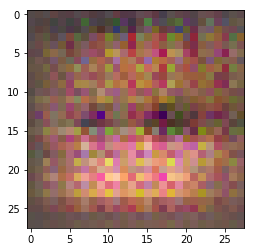

Epoch 1/2... Discriminator Loss: 0.5289... Generator Loss: 2.3445
Epoch 1/2... Discriminator Loss: 0.5299... Generator Loss: 3.4269
Epoch 1/2... Discriminator Loss: 0.4404... Generator Loss: 2.8163
Epoch 1/2... Discriminator Loss: 0.5024... Generator Loss: 4.9130
Epoch 1/2... Discriminator Loss: 0.4479... Generator Loss: 4.6215
Epoch 1/2... Discriminator Loss: 1.7469... Generator Loss: 7.6847
Epoch 1/2... Discriminator Loss: 0.5215... Generator Loss: 3.8034
Epoch 1/2... Discriminator Loss: 0.5325... Generator Loss: 2.7413
Epoch 1/2... Discriminator Loss: 0.4089... Generator Loss: 4.4434
Epoch 1/2... Discriminator Loss: 0.3792... Generator Loss: 4.6347


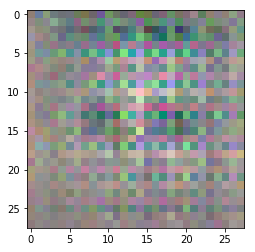

Epoch 1/2... Discriminator Loss: 0.5635... Generator Loss: 5.0337
Epoch 1/2... Discriminator Loss: 0.7171... Generator Loss: 1.5534
Epoch 1/2... Discriminator Loss: 0.6064... Generator Loss: 2.7655
Epoch 1/2... Discriminator Loss: 1.2180... Generator Loss: 1.4730
Epoch 1/2... Discriminator Loss: 0.4477... Generator Loss: 2.6992
Epoch 1/2... Discriminator Loss: 1.0153... Generator Loss: 1.4195
Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 0.6556
Epoch 1/2... Discriminator Loss: 0.6328... Generator Loss: 2.2240
Epoch 1/2... Discriminator Loss: 0.9319... Generator Loss: 1.2750
Epoch 1/2... Discriminator Loss: 0.8203... Generator Loss: 2.1475


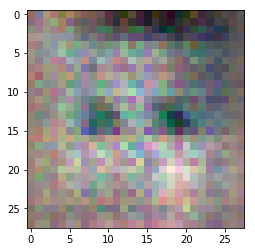

Epoch 1/2... Discriminator Loss: 0.8112... Generator Loss: 2.0255
Epoch 1/2... Discriminator Loss: 0.7208... Generator Loss: 1.6853
Epoch 1/2... Discriminator Loss: 1.4935... Generator Loss: 4.6667
Epoch 1/2... Discriminator Loss: 0.4518... Generator Loss: 2.5705
Epoch 1/2... Discriminator Loss: 0.9548... Generator Loss: 1.8038
Epoch 1/2... Discriminator Loss: 1.1029... Generator Loss: 4.3213
Epoch 1/2... Discriminator Loss: 1.5953... Generator Loss: 1.0742
Epoch 1/2... Discriminator Loss: 1.3397... Generator Loss: 0.9314
Epoch 1/2... Discriminator Loss: 0.7138... Generator Loss: 2.5264
Epoch 1/2... Discriminator Loss: 0.6569... Generator Loss: 1.7438


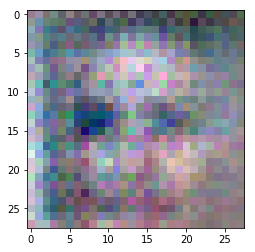

Epoch 1/2... Discriminator Loss: 1.1743... Generator Loss: 1.1281
Epoch 1/2... Discriminator Loss: 1.1103... Generator Loss: 0.7542
Epoch 1/2... Discriminator Loss: 1.7211... Generator Loss: 0.3786
Epoch 1/2... Discriminator Loss: 0.4240... Generator Loss: 3.1270
Epoch 1/2... Discriminator Loss: 0.4476... Generator Loss: 3.1026
Epoch 1/2... Discriminator Loss: 0.9098... Generator Loss: 1.8522
Epoch 1/2... Discriminator Loss: 0.9035... Generator Loss: 1.1690
Epoch 1/2... Discriminator Loss: 0.6945... Generator Loss: 2.1464
Epoch 1/2... Discriminator Loss: 0.4210... Generator Loss: 3.1203
Epoch 1/2... Discriminator Loss: 1.5644... Generator Loss: 1.4672


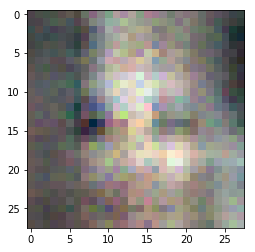

Epoch 1/2... Discriminator Loss: 0.4128... Generator Loss: 3.8200
Epoch 1/2... Discriminator Loss: 1.4252... Generator Loss: 0.5283
Epoch 1/2... Discriminator Loss: 1.4251... Generator Loss: 5.1759
Epoch 1/2... Discriminator Loss: 1.3278... Generator Loss: 0.5574
Epoch 1/2... Discriminator Loss: 0.9149... Generator Loss: 0.9756
Epoch 1/2... Discriminator Loss: 0.5242... Generator Loss: 2.2385
Epoch 1/2... Discriminator Loss: 0.6869... Generator Loss: 1.8327
Epoch 1/2... Discriminator Loss: 0.3733... Generator Loss: 9.0900
Epoch 1/2... Discriminator Loss: 1.1350... Generator Loss: 1.7746
Epoch 1/2... Discriminator Loss: 0.6330... Generator Loss: 1.6851


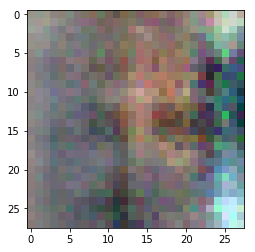

Epoch 1/2... Discriminator Loss: 0.4089... Generator Loss: 2.9371
Epoch 1/2... Discriminator Loss: 0.9384... Generator Loss: 1.1468
Epoch 1/2... Discriminator Loss: 1.0464... Generator Loss: 4.8052
Epoch 1/2... Discriminator Loss: 0.4101... Generator Loss: 3.9438
Epoch 1/2... Discriminator Loss: 0.6135... Generator Loss: 2.6466
Epoch 1/2... Discriminator Loss: 0.4212... Generator Loss: 2.8469
Epoch 1/2... Discriminator Loss: 0.3630... Generator Loss: 7.8058
Epoch 1/2... Discriminator Loss: 0.6156... Generator Loss: 10.1085
Epoch 1/2... Discriminator Loss: 0.3645... Generator Loss: 6.7945
Epoch 1/2... Discriminator Loss: 0.4083... Generator Loss: 3.0730


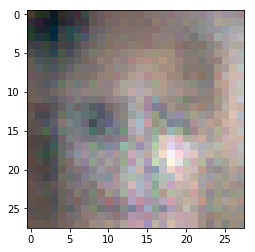

Epoch 1/2... Discriminator Loss: 0.5267... Generator Loss: 8.2938
Epoch 1/2... Discriminator Loss: 1.4238... Generator Loss: 3.6357
Epoch 1/2... Discriminator Loss: 0.5512... Generator Loss: 1.8732
Epoch 1/2... Discriminator Loss: 0.5422... Generator Loss: 1.9919
Epoch 1/2... Discriminator Loss: 0.6868... Generator Loss: 4.4466
Epoch 1/2... Discriminator Loss: 0.4742... Generator Loss: 2.2795
Epoch 1/2... Discriminator Loss: 0.3761... Generator Loss: 3.4694
Epoch 1/2... Discriminator Loss: 0.7157... Generator Loss: 1.2556
Epoch 1/2... Discriminator Loss: 0.5854... Generator Loss: 1.8738
Epoch 1/2... Discriminator Loss: 0.6090... Generator Loss: 1.5629


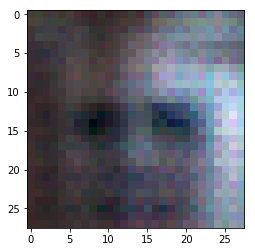

Epoch 1/2... Discriminator Loss: 1.1080... Generator Loss: 0.7463
Epoch 1/2... Discriminator Loss: 0.3482... Generator Loss: 6.0145
Epoch 1/2... Discriminator Loss: 0.3471... Generator Loss: 6.3396
Epoch 1/2... Discriminator Loss: 0.3481... Generator Loss: 5.1615
Epoch 1/2... Discriminator Loss: 0.3563... Generator Loss: 4.0637
Epoch 1/2... Discriminator Loss: 0.3464... Generator Loss: 5.3957
Epoch 1/2... Discriminator Loss: 0.4496... Generator Loss: 2.4624
Epoch 1/2... Discriminator Loss: 0.3398... Generator Loss: 7.8042
Epoch 1/2... Discriminator Loss: 0.3741... Generator Loss: 4.1097
Epoch 1/2... Discriminator Loss: 0.3465... Generator Loss: 5.8893


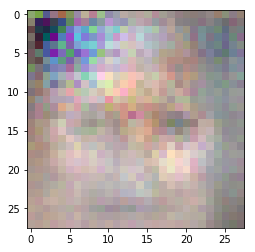

Epoch 1/2... Discriminator Loss: 0.3415... Generator Loss: 5.6519
Epoch 1/2... Discriminator Loss: 0.4994... Generator Loss: 1.9815
Epoch 1/2... Discriminator Loss: 0.3775... Generator Loss: 3.6867
Epoch 1/2... Discriminator Loss: 4.8795... Generator Loss: 6.0058
Epoch 1/2... Discriminator Loss: 0.8268... Generator Loss: 1.2548
Epoch 1/2... Discriminator Loss: 0.5328... Generator Loss: 4.7017
Epoch 1/2... Discriminator Loss: 2.3026... Generator Loss: 0.1770
Epoch 1/2... Discriminator Loss: 0.6053... Generator Loss: 1.6014
Epoch 1/2... Discriminator Loss: 0.4209... Generator Loss: 5.1082
Epoch 1/2... Discriminator Loss: 0.4715... Generator Loss: 2.5285


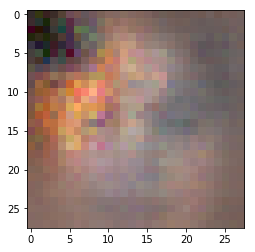

Epoch 1/2... Discriminator Loss: 0.9857... Generator Loss: 3.3773
Epoch 1/2... Discriminator Loss: 0.6873... Generator Loss: 1.3444
Epoch 1/2... Discriminator Loss: 0.4300... Generator Loss: 3.0614
Epoch 1/2... Discriminator Loss: 0.9131... Generator Loss: 0.9392
Epoch 1/2... Discriminator Loss: 0.6250... Generator Loss: 1.8494
Epoch 1/2... Discriminator Loss: 0.5194... Generator Loss: 3.3240
Epoch 1/2... Discriminator Loss: 1.1559... Generator Loss: 0.6801
Epoch 1/2... Discriminator Loss: 0.5453... Generator Loss: 1.9123
Epoch 1/2... Discriminator Loss: 0.3578... Generator Loss: 4.1381
Epoch 1/2... Discriminator Loss: 1.3030... Generator Loss: 6.7789


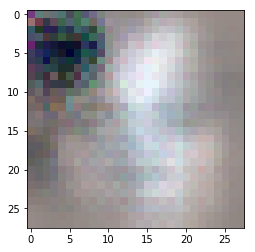

Epoch 1/2... Discriminator Loss: 0.4071... Generator Loss: 4.0155
Epoch 1/2... Discriminator Loss: 0.3764... Generator Loss: 3.6803
Epoch 1/2... Discriminator Loss: 0.5884... Generator Loss: 1.7529
Epoch 1/2... Discriminator Loss: 0.6710... Generator Loss: 1.5658
Epoch 1/2... Discriminator Loss: 0.4802... Generator Loss: 2.4533
Epoch 1/2... Discriminator Loss: 0.3930... Generator Loss: 3.7274
Epoch 1/2... Discriminator Loss: 0.4017... Generator Loss: 3.7637
Epoch 1/2... Discriminator Loss: 0.7522... Generator Loss: 2.9642
Epoch 1/2... Discriminator Loss: 0.3485... Generator Loss: 7.5976
Epoch 1/2... Discriminator Loss: 0.3520... Generator Loss: 5.2785


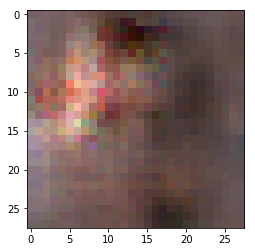

Epoch 1/2... Discriminator Loss: 0.3436... Generator Loss: 5.9941
Epoch 1/2... Discriminator Loss: 0.3648... Generator Loss: 5.4526
Epoch 1/2... Discriminator Loss: 0.3520... Generator Loss: 8.0829
Epoch 1/2... Discriminator Loss: 1.1228... Generator Loss: 1.3535
Epoch 1/2... Discriminator Loss: 0.9164... Generator Loss: 2.0375
Epoch 1/2... Discriminator Loss: 0.5031... Generator Loss: 3.5176
Epoch 1/2... Discriminator Loss: 0.3679... Generator Loss: 7.2245
Epoch 1/2... Discriminator Loss: 0.5085... Generator Loss: 2.6406
Epoch 1/2... Discriminator Loss: 0.4940... Generator Loss: 2.1596
Epoch 1/2... Discriminator Loss: 0.5752... Generator Loss: 2.5970


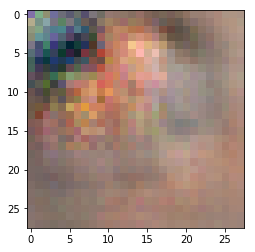

Epoch 1/2... Discriminator Loss: 0.3662... Generator Loss: 6.6718
Epoch 1/2... Discriminator Loss: 0.8401... Generator Loss: 0.9915
Epoch 1/2... Discriminator Loss: 0.8008... Generator Loss: 7.4164
Epoch 1/2... Discriminator Loss: 0.5494... Generator Loss: 1.9039
Epoch 1/2... Discriminator Loss: 0.4353... Generator Loss: 2.5970
Epoch 1/2... Discriminator Loss: 0.3621... Generator Loss: 6.1944
Epoch 1/2... Discriminator Loss: 0.6035... Generator Loss: 2.1244
Epoch 1/2... Discriminator Loss: 0.4460... Generator Loss: 3.4492
Epoch 1/2... Discriminator Loss: 0.3386... Generator Loss: 7.8858
Epoch 1/2... Discriminator Loss: 0.6886... Generator Loss: 1.4132


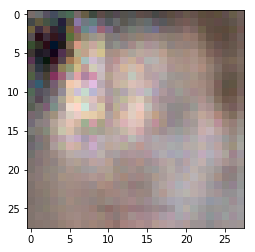

Epoch 1/2... Discriminator Loss: 0.4176... Generator Loss: 3.9333
Epoch 1/2... Discriminator Loss: 1.2278... Generator Loss: 3.0689
Epoch 1/2... Discriminator Loss: 0.4097... Generator Loss: 3.4849
Epoch 1/2... Discriminator Loss: 0.3687... Generator Loss: 5.0627
Epoch 1/2... Discriminator Loss: 0.5225... Generator Loss: 2.2182
Epoch 1/2... Discriminator Loss: 0.3486... Generator Loss: 6.3052
Epoch 1/2... Discriminator Loss: 0.9491... Generator Loss: 1.0468
Epoch 1/2... Discriminator Loss: 0.4234... Generator Loss: 4.4690
Epoch 1/2... Discriminator Loss: 0.5369... Generator Loss: 2.4631
Epoch 1/2... Discriminator Loss: 0.5887... Generator Loss: 1.6895


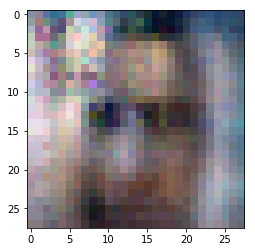

Epoch 1/2... Discriminator Loss: 0.4138... Generator Loss: 5.1949
Epoch 1/2... Discriminator Loss: 0.3510... Generator Loss: 6.4424
Epoch 1/2... Discriminator Loss: 0.5493... Generator Loss: 2.1684
Epoch 1/2... Discriminator Loss: 0.7774... Generator Loss: 1.2974
Epoch 1/2... Discriminator Loss: 0.4242... Generator Loss: 2.7082
Epoch 1/2... Discriminator Loss: 1.4919... Generator Loss: 2.6413
Epoch 1/2... Discriminator Loss: 0.8543... Generator Loss: 1.0551
Epoch 1/2... Discriminator Loss: 0.7795... Generator Loss: 1.2602
Epoch 1/2... Discriminator Loss: 0.3881... Generator Loss: 8.5224
Epoch 1/2... Discriminator Loss: 0.4383... Generator Loss: 2.4873


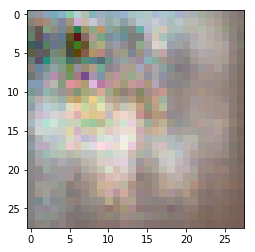

Epoch 1/2... Discriminator Loss: 0.3553... Generator Loss: 5.0201
Epoch 1/2... Discriminator Loss: 0.3654... Generator Loss: 6.1242
Epoch 1/2... Discriminator Loss: 0.3609... Generator Loss: 4.5789
Epoch 1/2... Discriminator Loss: 0.3542... Generator Loss: 6.4979
Epoch 1/2... Discriminator Loss: 0.3386... Generator Loss: 5.7687
Epoch 1/2... Discriminator Loss: 2.8355... Generator Loss: 0.1583
Epoch 1/2... Discriminator Loss: 1.0707... Generator Loss: 2.5159
Epoch 1/2... Discriminator Loss: 0.4321... Generator Loss: 2.6650
Epoch 1/2... Discriminator Loss: 0.5604... Generator Loss: 2.7092
Epoch 1/2... Discriminator Loss: 0.3456... Generator Loss: 7.0367


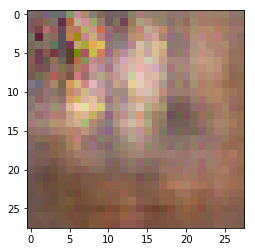

Epoch 1/2... Discriminator Loss: 0.3449... Generator Loss: 5.5482
Epoch 1/2... Discriminator Loss: 0.5264... Generator Loss: 5.2374
Epoch 1/2... Discriminator Loss: 0.3560... Generator Loss: 8.6775
Epoch 1/2... Discriminator Loss: 0.3587... Generator Loss: 4.1517
Epoch 1/2... Discriminator Loss: 0.3662... Generator Loss: 4.4231
Epoch 1/2... Discriminator Loss: 0.5390... Generator Loss: 1.7852
Epoch 1/2... Discriminator Loss: 0.3340... Generator Loss: 7.6092
Epoch 1/2... Discriminator Loss: 2.4331... Generator Loss: 0.1879
Epoch 1/2... Discriminator Loss: 0.4133... Generator Loss: 3.3567
Epoch 1/2... Discriminator Loss: 0.4291... Generator Loss: 3.4078


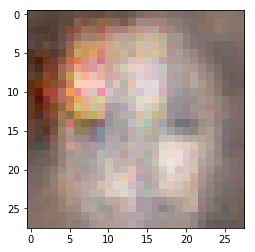

Epoch 1/2... Discriminator Loss: 0.4212... Generator Loss: 5.9235
Epoch 1/2... Discriminator Loss: 0.3593... Generator Loss: 4.6892
Epoch 1/2... Discriminator Loss: 0.9787... Generator Loss: 0.8919
Epoch 1/2... Discriminator Loss: 1.0145... Generator Loss: 1.3584
Epoch 1/2... Discriminator Loss: 0.4432... Generator Loss: 2.5499
Epoch 1/2... Discriminator Loss: 0.3538... Generator Loss: 5.5608
Epoch 1/2... Discriminator Loss: 0.5756... Generator Loss: 1.7873
Epoch 1/2... Discriminator Loss: 0.4067... Generator Loss: 8.2963
Epoch 1/2... Discriminator Loss: 1.6129... Generator Loss: 6.6262
Epoch 1/2... Discriminator Loss: 0.3551... Generator Loss: 5.8425


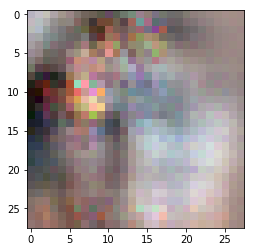

Epoch 1/2... Discriminator Loss: 0.5586... Generator Loss: 3.4255
Epoch 1/2... Discriminator Loss: 0.4820... Generator Loss: 5.3140
Epoch 1/2... Discriminator Loss: 0.8934... Generator Loss: 0.9994
Epoch 1/2... Discriminator Loss: 0.3571... Generator Loss: 5.4036
Epoch 1/2... Discriminator Loss: 0.3818... Generator Loss: 3.5711
Epoch 1/2... Discriminator Loss: 0.3805... Generator Loss: 4.8228
Epoch 1/2... Discriminator Loss: 0.3716... Generator Loss: 4.2440
Epoch 1/2... Discriminator Loss: 0.3564... Generator Loss: 6.2394
Epoch 1/2... Discriminator Loss: 1.2795... Generator Loss: 1.0137
Epoch 1/2... Discriminator Loss: 0.8274... Generator Loss: 1.1663


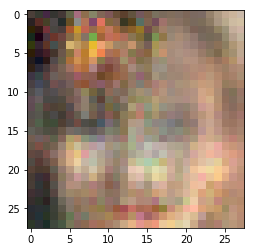

Epoch 1/2... Discriminator Loss: 1.7339... Generator Loss: 4.0926
Epoch 1/2... Discriminator Loss: 0.7556... Generator Loss: 1.2330
Epoch 1/2... Discriminator Loss: 0.5385... Generator Loss: 2.6848
Epoch 1/2... Discriminator Loss: 0.4847... Generator Loss: 2.2764
Epoch 1/2... Discriminator Loss: 0.4638... Generator Loss: 2.7635
Epoch 1/2... Discriminator Loss: 0.4102... Generator Loss: 5.5974
Epoch 1/2... Discriminator Loss: 0.3911... Generator Loss: 7.5475
Epoch 1/2... Discriminator Loss: 0.3689... Generator Loss: 4.4034
Epoch 1/2... Discriminator Loss: 0.3489... Generator Loss: 6.8785
Epoch 1/2... Discriminator Loss: 0.3426... Generator Loss: 5.9811


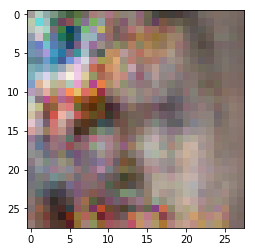

Epoch 1/2... Discriminator Loss: 0.5324... Generator Loss: 3.7152
Epoch 1/2... Discriminator Loss: 0.6376... Generator Loss: 1.4907
Epoch 1/2... Discriminator Loss: 0.4698... Generator Loss: 2.4146
Epoch 1/2... Discriminator Loss: 0.3866... Generator Loss: 6.9068
Epoch 1/2... Discriminator Loss: 0.3390... Generator Loss: 9.5487
Epoch 1/2... Discriminator Loss: 0.3531... Generator Loss: 5.1676
Epoch 1/2... Discriminator Loss: 0.6817... Generator Loss: 1.3704
Epoch 1/2... Discriminator Loss: 0.3699... Generator Loss: 3.9476
Epoch 1/2... Discriminator Loss: 0.3439... Generator Loss: 6.9358
Epoch 1/2... Discriminator Loss: 0.3510... Generator Loss: 6.6894


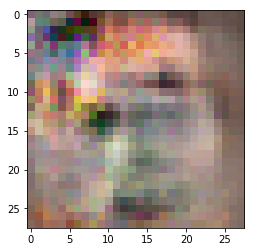

Epoch 1/2... Discriminator Loss: 0.7991... Generator Loss: 1.7584
Epoch 1/2... Discriminator Loss: 0.7545... Generator Loss: 1.6253
Epoch 1/2... Discriminator Loss: 0.8045... Generator Loss: 1.6024
Epoch 1/2... Discriminator Loss: 0.6885... Generator Loss: 1.5141
Epoch 1/2... Discriminator Loss: 0.7839... Generator Loss: 1.2888
Epoch 1/2... Discriminator Loss: 0.6507... Generator Loss: 1.5079
Epoch 1/2... Discriminator Loss: 0.6349... Generator Loss: 1.9623
Epoch 1/2... Discriminator Loss: 1.0163... Generator Loss: 0.8772
Epoch 1/2... Discriminator Loss: 0.5170... Generator Loss: 2.4394
Epoch 1/2... Discriminator Loss: 1.6417... Generator Loss: 4.0158


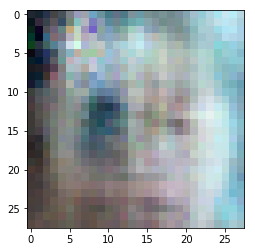

Epoch 1/2... Discriminator Loss: 0.5107... Generator Loss: 2.2246
Epoch 1/2... Discriminator Loss: 0.7156... Generator Loss: 7.7747
Epoch 1/2... Discriminator Loss: 0.4213... Generator Loss: 4.9105
Epoch 1/2... Discriminator Loss: 0.3645... Generator Loss: 6.9419
Epoch 1/2... Discriminator Loss: 0.3656... Generator Loss: 4.8165
Epoch 1/2... Discriminator Loss: 0.5167... Generator Loss: 4.9497
Epoch 1/2... Discriminator Loss: 0.7211... Generator Loss: 1.5372
Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 2.2161
Epoch 1/2... Discriminator Loss: 0.5671... Generator Loss: 1.9762
Epoch 1/2... Discriminator Loss: 0.9076... Generator Loss: 1.0249


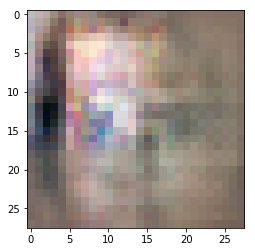

Epoch 1/2... Discriminator Loss: 0.4654... Generator Loss: 2.9501
Epoch 1/2... Discriminator Loss: 0.3638... Generator Loss: 5.0335
Epoch 1/2... Discriminator Loss: 0.3544... Generator Loss: 6.7457
Epoch 1/2... Discriminator Loss: 0.3849... Generator Loss: 6.9090
Epoch 1/2... Discriminator Loss: 1.2666... Generator Loss: 0.5574
Epoch 1/2... Discriminator Loss: 0.4440... Generator Loss: 3.7868
Epoch 1/2... Discriminator Loss: 0.4383... Generator Loss: 3.3670
Epoch 1/2... Discriminator Loss: 0.4239... Generator Loss: 2.9570
Epoch 1/2... Discriminator Loss: 0.3573... Generator Loss: 6.3951
Epoch 1/2... Discriminator Loss: 0.8480... Generator Loss: 1.0242


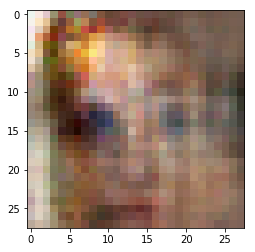

Epoch 1/2... Discriminator Loss: 0.8501... Generator Loss: 2.3605
Epoch 1/2... Discriminator Loss: 0.6297... Generator Loss: 1.6530
Epoch 1/2... Discriminator Loss: 0.8672... Generator Loss: 1.1050
Epoch 1/2... Discriminator Loss: 0.4659... Generator Loss: 3.5808
Epoch 1/2... Discriminator Loss: 0.3901... Generator Loss: 3.4596
Epoch 1/2... Discriminator Loss: 0.8058... Generator Loss: 4.4793
Epoch 1/2... Discriminator Loss: 0.4381... Generator Loss: 2.7200
Epoch 1/2... Discriminator Loss: 0.7284... Generator Loss: 5.0829
Epoch 1/2... Discriminator Loss: 0.9062... Generator Loss: 0.9810
Epoch 1/2... Discriminator Loss: 0.5334... Generator Loss: 1.9351


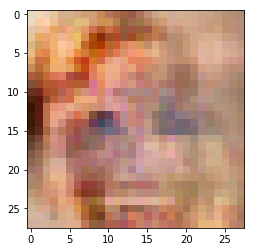

Epoch 1/2... Discriminator Loss: 0.6412... Generator Loss: 1.5197
Epoch 1/2... Discriminator Loss: 0.5071... Generator Loss: 2.5203
Epoch 1/2... Discriminator Loss: 0.3870... Generator Loss: 3.5397
Epoch 1/2... Discriminator Loss: 0.4697... Generator Loss: 3.0054
Epoch 1/2... Discriminator Loss: 0.6424... Generator Loss: 1.5016
Epoch 1/2... Discriminator Loss: 0.4649... Generator Loss: 5.4238
Epoch 1/2... Discriminator Loss: 1.2291... Generator Loss: 5.4939
Epoch 1/2... Discriminator Loss: 0.7639... Generator Loss: 1.7041
Epoch 1/2... Discriminator Loss: 0.6755... Generator Loss: 1.4706
Epoch 1/2... Discriminator Loss: 0.5679... Generator Loss: 1.8835


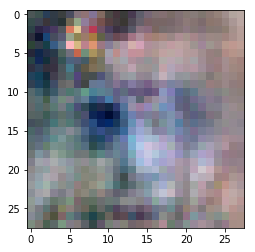

Epoch 1/2... Discriminator Loss: 0.4765... Generator Loss: 2.6190
Epoch 1/2... Discriminator Loss: 0.3771... Generator Loss: 4.3019
Epoch 1/2... Discriminator Loss: 1.2545... Generator Loss: 4.2086
Epoch 1/2... Discriminator Loss: 0.6516... Generator Loss: 1.5825
Epoch 1/2... Discriminator Loss: 0.4695... Generator Loss: 3.0555
Epoch 1/2... Discriminator Loss: 0.8347... Generator Loss: 1.1197
Epoch 1/2... Discriminator Loss: 0.3462... Generator Loss: 6.6440
Epoch 1/2... Discriminator Loss: 0.7325... Generator Loss: 1.3436
Epoch 1/2... Discriminator Loss: 1.6214... Generator Loss: 4.7929
Epoch 1/2... Discriminator Loss: 0.6613... Generator Loss: 1.4637


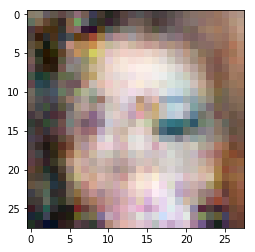

Epoch 1/2... Discriminator Loss: 0.4901... Generator Loss: 5.4812
Epoch 1/2... Discriminator Loss: 0.4691... Generator Loss: 6.1177
Epoch 1/2... Discriminator Loss: 0.4312... Generator Loss: 3.6072
Epoch 1/2... Discriminator Loss: 1.2520... Generator Loss: 0.6198
Epoch 1/2... Discriminator Loss: 0.5251... Generator Loss: 2.3178
Epoch 1/2... Discriminator Loss: 0.4121... Generator Loss: 3.0359
Epoch 1/2... Discriminator Loss: 0.6639... Generator Loss: 1.4657
Epoch 1/2... Discriminator Loss: 0.4714... Generator Loss: 5.8393
Epoch 1/2... Discriminator Loss: 0.5913... Generator Loss: 4.4295
Epoch 1/2... Discriminator Loss: 0.3818... Generator Loss: 3.5497


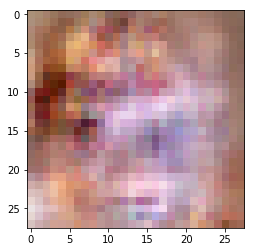

Epoch 1/2... Discriminator Loss: 0.8618... Generator Loss: 1.0431
Epoch 1/2... Discriminator Loss: 0.3451... Generator Loss: 6.1622
Epoch 1/2... Discriminator Loss: 0.4901... Generator Loss: 2.1409
Epoch 1/2... Discriminator Loss: 8.0806... Generator Loss: 9.4024
Epoch 1/2... Discriminator Loss: 1.0356... Generator Loss: 1.0967
Epoch 1/2... Discriminator Loss: 0.9252... Generator Loss: 1.2391
Epoch 1/2... Discriminator Loss: 1.0379... Generator Loss: 0.9612
Epoch 1/2... Discriminator Loss: 1.0073... Generator Loss: 1.5911
Epoch 1/2... Discriminator Loss: 1.0483... Generator Loss: 1.0887
Epoch 1/2... Discriminator Loss: 0.9549... Generator Loss: 0.9008


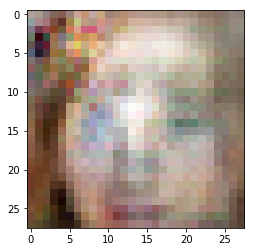

Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 0.9409
Epoch 1/2... Discriminator Loss: 0.8699... Generator Loss: 1.9830
Epoch 1/2... Discriminator Loss: 1.0283... Generator Loss: 3.3758
Epoch 1/2... Discriminator Loss: 0.8921... Generator Loss: 1.1512
Epoch 1/2... Discriminator Loss: 1.0480... Generator Loss: 0.9912
Epoch 1/2... Discriminator Loss: 0.7876... Generator Loss: 2.2814
Epoch 1/2... Discriminator Loss: 0.6669... Generator Loss: 1.8036
Epoch 1/2... Discriminator Loss: 0.6207... Generator Loss: 1.6849
Epoch 1/2... Discriminator Loss: 0.7526... Generator Loss: 2.3351
Epoch 1/2... Discriminator Loss: 0.6287... Generator Loss: 1.8569


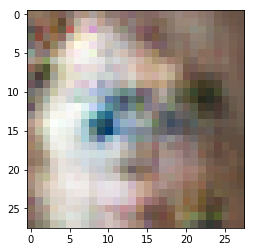

Epoch 1/2... Discriminator Loss: 0.7608... Generator Loss: 3.8939
Epoch 1/2... Discriminator Loss: 0.6357... Generator Loss: 2.4501
Epoch 1/2... Discriminator Loss: 0.4591... Generator Loss: 2.6529
Epoch 1/2... Discriminator Loss: 0.7092... Generator Loss: 1.3994
Epoch 1/2... Discriminator Loss: 0.3792... Generator Loss: 4.0762
Epoch 1/2... Discriminator Loss: 0.4207... Generator Loss: 3.2643
Epoch 2/2... Discriminator Loss: 0.7194... Generator Loss: 1.3565
Epoch 2/2... Discriminator Loss: 0.4042... Generator Loss: 3.8678
Epoch 2/2... Discriminator Loss: 0.3995... Generator Loss: 4.1278
Epoch 2/2... Discriminator Loss: 0.6077... Generator Loss: 1.9898
Epoch 2/2... Discriminator Loss: 0.4588... Generator Loss: 3.7782
Epoch 2/2... Discriminator Loss: 0.6204... Generator Loss: 1.7963
Epoch 2/2... Discriminator Loss: 0.9332... Generator Loss: 0.9854
Epoch 2/2... Discriminator Loss: 0.7887... Generator Loss: 1.4211
Epoch 2/2... Discriminator Loss: 0.4972... Generator Loss: 2.5701
Epoch 2/2.

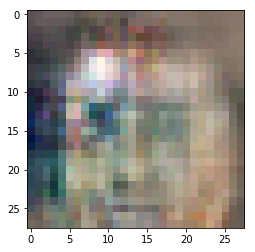

Epoch 2/2... Discriminator Loss: 0.5967... Generator Loss: 1.9577
Epoch 2/2... Discriminator Loss: 0.6306... Generator Loss: 1.6992
Epoch 2/2... Discriminator Loss: 0.5529... Generator Loss: 2.0699
Epoch 2/2... Discriminator Loss: 0.8013... Generator Loss: 1.1694
Epoch 2/2... Discriminator Loss: 1.0573... Generator Loss: 5.4616
Epoch 2/2... Discriminator Loss: 0.5624... Generator Loss: 2.0882
Epoch 2/2... Discriminator Loss: 0.3566... Generator Loss: 7.2318
Epoch 2/2... Discriminator Loss: 0.6818... Generator Loss: 1.5276
Epoch 2/2... Discriminator Loss: 0.3603... Generator Loss: 4.8345
Epoch 2/2... Discriminator Loss: 1.6170... Generator Loss: 0.7090


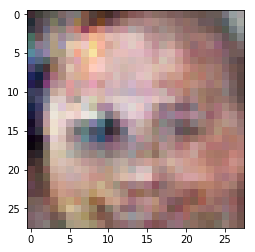

Epoch 2/2... Discriminator Loss: 0.8329... Generator Loss: 1.6200
Epoch 2/2... Discriminator Loss: 0.9708... Generator Loss: 1.7015
Epoch 2/2... Discriminator Loss: 0.8578... Generator Loss: 1.2511
Epoch 2/2... Discriminator Loss: 0.5100... Generator Loss: 3.5330
Epoch 2/2... Discriminator Loss: 0.6222... Generator Loss: 1.6817
Epoch 2/2... Discriminator Loss: 0.9553... Generator Loss: 1.0614
Epoch 2/2... Discriminator Loss: 1.1702... Generator Loss: 0.7119
Epoch 2/2... Discriminator Loss: 0.4895... Generator Loss: 2.9697
Epoch 2/2... Discriminator Loss: 0.6818... Generator Loss: 1.4299
Epoch 2/2... Discriminator Loss: 0.5741... Generator Loss: 1.8112


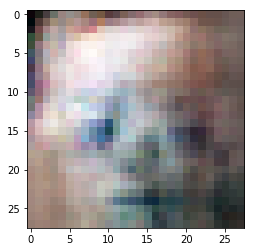

Epoch 2/2... Discriminator Loss: 0.6154... Generator Loss: 1.7575
Epoch 2/2... Discriminator Loss: 0.4401... Generator Loss: 2.8315
Epoch 2/2... Discriminator Loss: 0.5766... Generator Loss: 1.9677
Epoch 2/2... Discriminator Loss: 0.4092... Generator Loss: 3.5819
Epoch 2/2... Discriminator Loss: 0.3760... Generator Loss: 4.0740
Epoch 2/2... Discriminator Loss: 0.5153... Generator Loss: 2.2233
Epoch 2/2... Discriminator Loss: 0.5192... Generator Loss: 2.0727
Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 1.2703
Epoch 2/2... Discriminator Loss: 0.6376... Generator Loss: 1.7588
Epoch 2/2... Discriminator Loss: 0.9234... Generator Loss: 2.7995


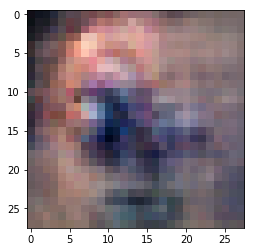

Epoch 2/2... Discriminator Loss: 0.4567... Generator Loss: 3.5430
Epoch 2/2... Discriminator Loss: 0.4483... Generator Loss: 2.5876
Epoch 2/2... Discriminator Loss: 0.4269... Generator Loss: 3.4595
Epoch 2/2... Discriminator Loss: 1.7581... Generator Loss: 0.3871
Epoch 2/2... Discriminator Loss: 0.5557... Generator Loss: 2.0825
Epoch 2/2... Discriminator Loss: 0.5819... Generator Loss: 2.0725
Epoch 2/2... Discriminator Loss: 0.4985... Generator Loss: 2.7683
Epoch 2/2... Discriminator Loss: 0.8245... Generator Loss: 1.2088
Epoch 2/2... Discriminator Loss: 0.8943... Generator Loss: 1.0049
Epoch 2/2... Discriminator Loss: 0.4653... Generator Loss: 2.4940


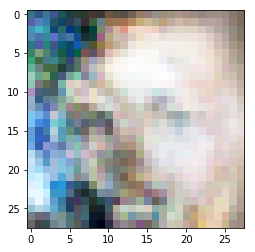

Epoch 2/2... Discriminator Loss: 0.7686... Generator Loss: 1.2429
Epoch 2/2... Discriminator Loss: 0.4753... Generator Loss: 5.7739
Epoch 2/2... Discriminator Loss: 0.3636... Generator Loss: 4.6300
Epoch 2/2... Discriminator Loss: 1.7015... Generator Loss: 4.5697
Epoch 2/2... Discriminator Loss: 0.7487... Generator Loss: 1.3344
Epoch 2/2... Discriminator Loss: 0.3640... Generator Loss: 5.2082
Epoch 2/2... Discriminator Loss: 0.3578... Generator Loss: 6.1413
Epoch 2/2... Discriminator Loss: 0.3530... Generator Loss: 5.3814
Epoch 2/2... Discriminator Loss: 1.6947... Generator Loss: 0.4238
Epoch 2/2... Discriminator Loss: 0.9928... Generator Loss: 2.9724


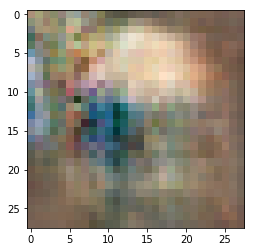

Epoch 2/2... Discriminator Loss: 0.4136... Generator Loss: 3.3055
Epoch 2/2... Discriminator Loss: 0.4693... Generator Loss: 2.9109
Epoch 2/2... Discriminator Loss: 0.8455... Generator Loss: 3.4130
Epoch 2/2... Discriminator Loss: 0.7746... Generator Loss: 1.6222
Epoch 2/2... Discriminator Loss: 0.4495... Generator Loss: 2.6545
Epoch 2/2... Discriminator Loss: 0.3638... Generator Loss: 5.0298
Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 1.2709
Epoch 2/2... Discriminator Loss: 1.0143... Generator Loss: 0.8897
Epoch 2/2... Discriminator Loss: 0.6942... Generator Loss: 1.4381
Epoch 2/2... Discriminator Loss: 0.6693... Generator Loss: 1.6313


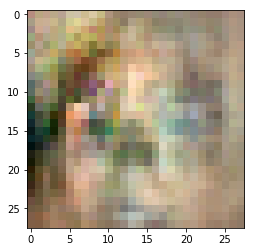

Epoch 2/2... Discriminator Loss: 0.7395... Generator Loss: 1.3616
Epoch 2/2... Discriminator Loss: 0.9146... Generator Loss: 1.0331
Epoch 2/2... Discriminator Loss: 0.5227... Generator Loss: 2.9308
Epoch 2/2... Discriminator Loss: 0.6096... Generator Loss: 1.8479
Epoch 2/2... Discriminator Loss: 0.5208... Generator Loss: 2.1373
Epoch 2/2... Discriminator Loss: 1.9740... Generator Loss: 0.2755
Epoch 2/2... Discriminator Loss: 0.7297... Generator Loss: 1.4529
Epoch 2/2... Discriminator Loss: 0.6527... Generator Loss: 1.7158
Epoch 2/2... Discriminator Loss: 0.3936... Generator Loss: 3.4872
Epoch 2/2... Discriminator Loss: 0.5728... Generator Loss: 3.8258


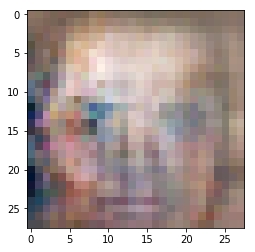

Epoch 2/2... Discriminator Loss: 0.7562... Generator Loss: 1.3402
Epoch 2/2... Discriminator Loss: 0.7918... Generator Loss: 1.1956
Epoch 2/2... Discriminator Loss: 0.3978... Generator Loss: 3.8221
Epoch 2/2... Discriminator Loss: 0.6528... Generator Loss: 1.6566
Epoch 2/2... Discriminator Loss: 0.5000... Generator Loss: 2.3936
Epoch 2/2... Discriminator Loss: 1.3184... Generator Loss: 0.5685
Epoch 2/2... Discriminator Loss: 0.6849... Generator Loss: 1.7686
Epoch 2/2... Discriminator Loss: 0.6168... Generator Loss: 1.6911
Epoch 2/2... Discriminator Loss: 0.7754... Generator Loss: 1.4218
Epoch 2/2... Discriminator Loss: 1.0190... Generator Loss: 3.3783


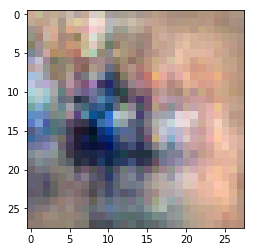

Epoch 2/2... Discriminator Loss: 0.7229... Generator Loss: 1.5872
Epoch 2/2... Discriminator Loss: 0.4198... Generator Loss: 2.9944
Epoch 2/2... Discriminator Loss: 0.4885... Generator Loss: 2.4956
Epoch 2/2... Discriminator Loss: 0.7003... Generator Loss: 1.4792
Epoch 2/2... Discriminator Loss: 0.5454... Generator Loss: 2.1854
Epoch 2/2... Discriminator Loss: 0.5214... Generator Loss: 2.1540
Epoch 2/2... Discriminator Loss: 0.4785... Generator Loss: 2.4105
Epoch 2/2... Discriminator Loss: 0.8591... Generator Loss: 1.1934
Epoch 2/2... Discriminator Loss: 0.4431... Generator Loss: 2.7749
Epoch 2/2... Discriminator Loss: 0.7833... Generator Loss: 1.2857


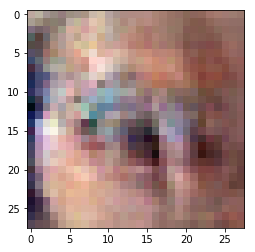

Epoch 2/2... Discriminator Loss: 0.4357... Generator Loss: 3.0460
Epoch 2/2... Discriminator Loss: 0.9870... Generator Loss: 3.3087
Epoch 2/2... Discriminator Loss: 0.5175... Generator Loss: 3.9267
Epoch 2/2... Discriminator Loss: 0.7208... Generator Loss: 2.1010
Epoch 2/2... Discriminator Loss: 0.5240... Generator Loss: 2.1338
Epoch 2/2... Discriminator Loss: 0.7312... Generator Loss: 2.9696
Epoch 2/2... Discriminator Loss: 0.4321... Generator Loss: 3.4513
Epoch 2/2... Discriminator Loss: 0.6596... Generator Loss: 1.4722
Epoch 2/2... Discriminator Loss: 0.4113... Generator Loss: 3.0802
Epoch 2/2... Discriminator Loss: 0.7556... Generator Loss: 1.3518


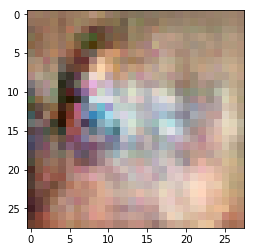

Epoch 2/2... Discriminator Loss: 0.6362... Generator Loss: 2.7477
Epoch 2/2... Discriminator Loss: 0.9325... Generator Loss: 0.9872
Epoch 2/2... Discriminator Loss: 0.6243... Generator Loss: 2.1457
Epoch 2/2... Discriminator Loss: 0.5336... Generator Loss: 2.3235
Epoch 2/2... Discriminator Loss: 1.3684... Generator Loss: 0.5097
Epoch 2/2... Discriminator Loss: 0.5114... Generator Loss: 3.5721
Epoch 2/2... Discriminator Loss: 1.0253... Generator Loss: 0.9035
Epoch 2/2... Discriminator Loss: 0.4794... Generator Loss: 2.3513
Epoch 2/2... Discriminator Loss: 0.5782... Generator Loss: 2.0612
Epoch 2/2... Discriminator Loss: 0.8866... Generator Loss: 1.3462


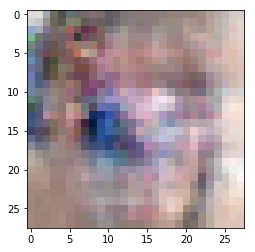

Epoch 2/2... Discriminator Loss: 0.7519... Generator Loss: 2.0131
Epoch 2/2... Discriminator Loss: 0.3925... Generator Loss: 3.7620
Epoch 2/2... Discriminator Loss: 0.3510... Generator Loss: 7.3280
Epoch 2/2... Discriminator Loss: 0.3572... Generator Loss: 5.8848
Epoch 2/2... Discriminator Loss: 2.5754... Generator Loss: 0.1491
Epoch 2/2... Discriminator Loss: 0.6773... Generator Loss: 4.6440
Epoch 2/2... Discriminator Loss: 0.8806... Generator Loss: 1.2624
Epoch 2/2... Discriminator Loss: 0.5985... Generator Loss: 1.9041
Epoch 2/2... Discriminator Loss: 0.6360... Generator Loss: 1.6808
Epoch 2/2... Discriminator Loss: 0.3617... Generator Loss: 5.9473


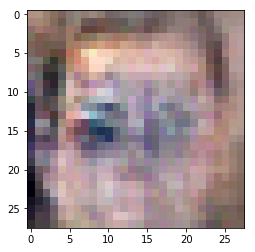

Epoch 2/2... Discriminator Loss: 3.3879... Generator Loss: 5.2657
Epoch 2/2... Discriminator Loss: 0.7700... Generator Loss: 1.4080
Epoch 2/2... Discriminator Loss: 0.4413... Generator Loss: 2.9550
Epoch 2/2... Discriminator Loss: 0.9449... Generator Loss: 6.1976
Epoch 2/2... Discriminator Loss: 0.6408... Generator Loss: 2.1665
Epoch 2/2... Discriminator Loss: 0.7069... Generator Loss: 1.9176
Epoch 2/2... Discriminator Loss: 0.8260... Generator Loss: 1.2148
Epoch 2/2... Discriminator Loss: 0.6088... Generator Loss: 3.9607
Epoch 2/2... Discriminator Loss: 0.5470... Generator Loss: 2.0186
Epoch 2/2... Discriminator Loss: 0.5807... Generator Loss: 2.0362


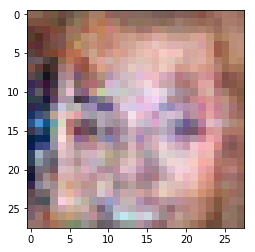

Epoch 2/2... Discriminator Loss: 0.7733... Generator Loss: 1.2605
Epoch 2/2... Discriminator Loss: 0.7423... Generator Loss: 4.0653
Epoch 2/2... Discriminator Loss: 1.0102... Generator Loss: 0.9344
Epoch 2/2... Discriminator Loss: 0.7423... Generator Loss: 1.3438
Epoch 2/2... Discriminator Loss: 0.4535... Generator Loss: 3.1099
Epoch 2/2... Discriminator Loss: 0.7776... Generator Loss: 1.3187
Epoch 2/2... Discriminator Loss: 0.6729... Generator Loss: 1.5034
Epoch 2/2... Discriminator Loss: 1.5111... Generator Loss: 0.4566
Epoch 2/2... Discriminator Loss: 0.7219... Generator Loss: 1.9859
Epoch 2/2... Discriminator Loss: 0.7905... Generator Loss: 1.2088


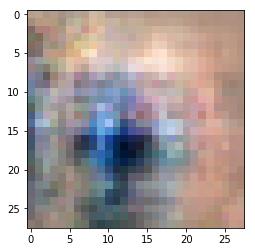

Epoch 2/2... Discriminator Loss: 0.5022... Generator Loss: 2.5360
Epoch 2/2... Discriminator Loss: 0.4736... Generator Loss: 2.7587
Epoch 2/2... Discriminator Loss: 0.5965... Generator Loss: 1.8160
Epoch 2/2... Discriminator Loss: 0.7644... Generator Loss: 3.4206
Epoch 2/2... Discriminator Loss: 0.4564... Generator Loss: 4.9348
Epoch 2/2... Discriminator Loss: 0.5458... Generator Loss: 2.9678
Epoch 2/2... Discriminator Loss: 0.5119... Generator Loss: 3.9166
Epoch 2/2... Discriminator Loss: 0.6804... Generator Loss: 1.7852
Epoch 2/2... Discriminator Loss: 0.6269... Generator Loss: 1.7577
Epoch 2/2... Discriminator Loss: 1.8832... Generator Loss: 0.3272


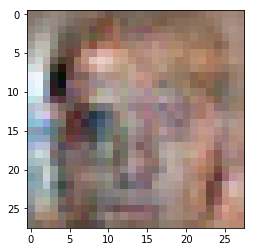

Epoch 2/2... Discriminator Loss: 0.9497... Generator Loss: 1.0638
Epoch 2/2... Discriminator Loss: 0.6659... Generator Loss: 1.7697
Epoch 2/2... Discriminator Loss: 0.6487... Generator Loss: 1.6068
Epoch 2/2... Discriminator Loss: 0.9508... Generator Loss: 1.0206
Epoch 2/2... Discriminator Loss: 0.8233... Generator Loss: 1.1038
Epoch 2/2... Discriminator Loss: 0.8360... Generator Loss: 1.1118
Epoch 2/2... Discriminator Loss: 0.5796... Generator Loss: 2.2799
Epoch 2/2... Discriminator Loss: 0.6251... Generator Loss: 2.6429
Epoch 2/2... Discriminator Loss: 0.6758... Generator Loss: 1.8042
Epoch 2/2... Discriminator Loss: 2.3880... Generator Loss: 0.2144


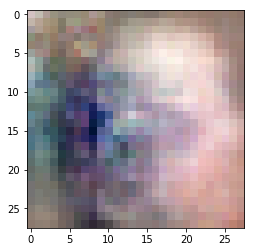

Epoch 2/2... Discriminator Loss: 0.7812... Generator Loss: 1.5699
Epoch 2/2... Discriminator Loss: 0.8071... Generator Loss: 1.2315
Epoch 2/2... Discriminator Loss: 1.0793... Generator Loss: 3.2713
Epoch 2/2... Discriminator Loss: 0.6763... Generator Loss: 1.5495
Epoch 2/2... Discriminator Loss: 0.6596... Generator Loss: 1.5422
Epoch 2/2... Discriminator Loss: 0.6119... Generator Loss: 2.0175
Epoch 2/2... Discriminator Loss: 0.4806... Generator Loss: 2.4207
Epoch 2/2... Discriminator Loss: 0.7450... Generator Loss: 1.9992
Epoch 2/2... Discriminator Loss: 1.1240... Generator Loss: 2.6942
Epoch 2/2... Discriminator Loss: 0.7528... Generator Loss: 1.3548


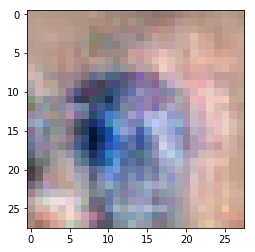

Epoch 2/2... Discriminator Loss: 0.6487... Generator Loss: 2.2319
Epoch 2/2... Discriminator Loss: 0.7583... Generator Loss: 1.4766
Epoch 2/2... Discriminator Loss: 0.6774... Generator Loss: 1.8075
Epoch 2/2... Discriminator Loss: 0.9593... Generator Loss: 0.9454
Epoch 2/2... Discriminator Loss: 0.6475... Generator Loss: 1.8171
Epoch 2/2... Discriminator Loss: 1.0130... Generator Loss: 0.9070
Epoch 2/2... Discriminator Loss: 0.7190... Generator Loss: 1.4270
Epoch 2/2... Discriminator Loss: 0.9939... Generator Loss: 0.8785
Epoch 2/2... Discriminator Loss: 1.3637... Generator Loss: 0.5683
Epoch 2/2... Discriminator Loss: 0.7103... Generator Loss: 1.5651


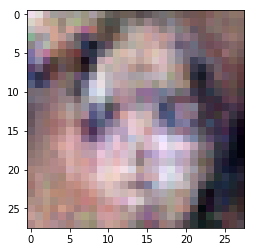

Epoch 2/2... Discriminator Loss: 0.3723... Generator Loss: 4.0549
Epoch 2/2... Discriminator Loss: 1.0005... Generator Loss: 1.7447
Epoch 2/2... Discriminator Loss: 1.2054... Generator Loss: 0.6923
Epoch 2/2... Discriminator Loss: 1.0163... Generator Loss: 0.8987


KeyboardInterrupt: 

In [29]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。